# TLDR - Logistic regression in PyTorch

Find a logistic regressor by successive approximation using mini-batch gradient descent.

---
tags: pytorch, tutorial, tldr, logistic regression, dataloader, mini-batch gradient descent, optimizer, module

In [1]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Data
# Samples
n_batches = 8
batch_size = 4
N = (n_batches - 1)*batch_size + batch_size//3 # size of dataset

x0 = -1. + .3*torch.randn(N//3, 1)
targs0 = torch.zeros_like(x0)
x1 = .4*torch.randn(N - N//3, 1)
targs1 = torch.ones_like(x1)
x = torch.cat([x0, x1])
targs = torch.cat([targs0, targs1])

# Dataset
ds = TensorDataset(x, targs)

# Dataloader
dl = DataLoader(ds, batch_size, shuffle=False, drop_last=False) # drop_last=True

X = torch.linspace(x.min(), x.max(), 101)[:,None] # for visualization

# Custom `LogisticRegressor` class
class LogisticRegressor(nn.Module):
    def __init__(self):
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        y = torch.sigmoid(self.linear(x))
        return y

# Instantiate model
model = LogisticRegressor()

# Loss function
criterion = torch.nn.BCELoss(reduction='mean')

# Learning rate
lr = 1

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training with mini-batch gradient descent
losses = []
approximations = []
weights = []
biases = []

n_epochs = 20

for epoch in range(n_epochs):
    for x_b, targs_b in dl:
        preds_b = model(x_b)
        loss_b = criterion(preds_b, targs_b)
        loss_b.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            preds = model(x)
            loss = criterion(preds, targs)
            approximation = model(X)

        losses.append(loss.item())
        approximations.append(approximation)
        weights.append(model.linear.weight.item())
        biases.append(model.linear.bias.item())

# Losses and successive approximations

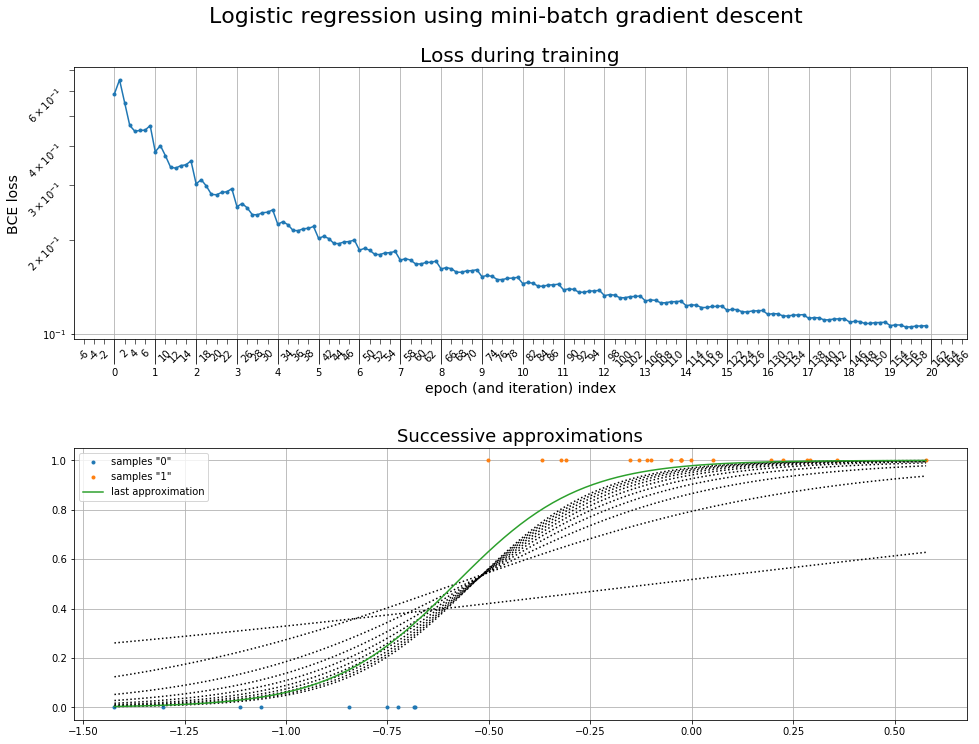

In [2]:
fig, axs = plt.subplots(2, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=.4)

ax = axs[0]
ax.plot(losses, '.-');
ax.set_yscale('log')
ax.set_xlabel("Epoch (iteration) index", fontsize=14)
ax.set_ylabel("BCE loss", fontsize=14)
ax.set_title("Loss during training", fontsize=20)
ax.grid();
ax.xaxis.set_major_locator(ticker.MultipleLocator(n_batches))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(n_batches//4))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t, pos: f"{t//n_batches:.0f}"))
ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda t, pos: f"{t:.0f}"))
ax.tick_params(which='major', axis='x', length=25)
ax.tick_params(which='minor', labelrotation=45, length=5)
ax.set_xlabel("epoch (and iteration) index", fontsize=14);


ax = axs[1]
ax.plot(x0, targs0, '.', label='samples "0"')
ax.plot(x1, targs1, '.', label='samples "1"')

for approximation in approximations[::len(approximations)//10]:
    ax.plot(X, approximation.detach().numpy(), "k:")
ax.plot(X, approximations[-1].detach().numpy(), label='last approximation')
ax.legend();
ax.set_title("Successive approximations", fontsize=18)
ax.grid();

fig.suptitle("Logistic regression using mini-batch gradient descent", fontsize=22, y=.95);

# Weight, bias, and location of front during training

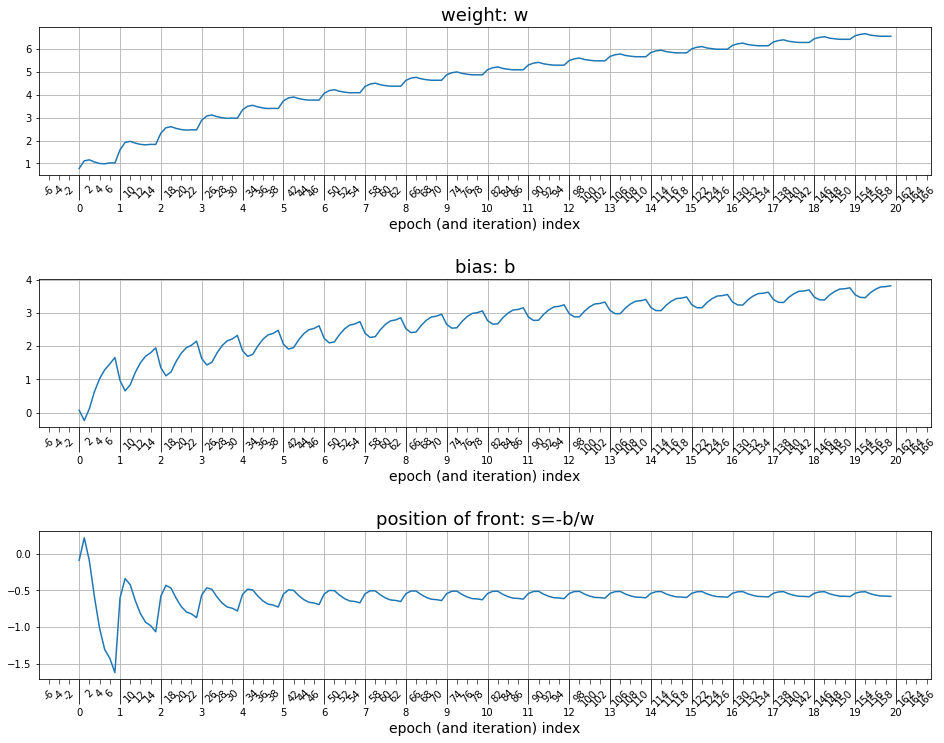

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=.7)

ax = axs[0]
ax.plot(weights)
ax.set_title("weight: w", fontsize=18)

ax = axs[1]
ax.plot(biases)
ax.set_title("bias: b", fontsize=18)


ax = axs[2]
ax.plot([-b/w for b, w in zip(biases, weights)])
ax.set_title("position of front: s=-b/w", fontsize=18)

for ax in axs:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(n_batches))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(n_batches//4))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t, pos: f"{t//n_batches:.0f}"))
    ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda t, pos: f"{t:.0f}"))
    ax.tick_params(which='major', axis='x', length=25)
    ax.tick_params(which='minor', labelrotation=45, length=5)
    ax.set_xlabel("epoch (and iteration) index", fontsize=14);


    ax.grid();